## Nonlinear constrained convex optimization problem
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We are interested in a constrained convex optimization problem
\begin{align*}
\min_{x} &\quad  f(x)\\
& h_i(x)  \leq 0, \quad i=1,\dots,m, \\
& x \in C,
\end{align*}

where $f, h_i \colon \R^n \to \R$ are smooth convex functions, $C\in \R^n$ is a convex set, which encodes simple constraints (projection on which are simple). 

Introducing Lagrange multipliers $y_i$ for each of constraints, we obtain
$$\min_{x\in C}\max_{y \in \R^m_+} f(x) + \sum_{i=1}^m y_i h_i(x)$$

Then $$F(x,y) = \binom{\nabla f(x) + \lr{y,\nabla h(x)}}{-h(x)},$$
where $h(x) = (h_1(x),\dots, h_m(x))$, and thus, $\nabla h(x) = (\nabla h_1(x),\dots, \nabla h_m(x))$


In [3]:
import matplotlib.pyplot as plt
import scipy.sparse as sr

from methods.algorithms_terminate import *
from misc.opt_operators import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
d = 500
m = d-1

# fix random generator
gen = 2
np.random.seed(gen)
c = np.random.uniform(0,10,d)

f = lambda x: c.dot(x)
df = lambda x: c

def prox_g(z,eps):
    x,y = z[:d], z[d:]
    x1 = np.fmax(x,-10)
    y1 = np.fmax(y,0)
    return np.hstack([x1,y1])

h = lambda x: np.exp(x)[:-1]- x[1:] - 2

def dh_sparse(x):
    e_x = np.exp(x[:-1])
    data = [e_x, -np.ones(d-1)]
    offsets = [0,1]
    D = sr.diags(data, offsets, shape=(d-1, d), format='csr')
    return D.T

def F_sparse(z):
    x,y = z[:d], z[d:]
    x1 = df(x) + dh_sparse(x).dot(y)
    y1 = - h(x)
    return np.hstack([x1,y1])

# We can also use non-sparse representation, but it is more efficient only for d<300
def dh(x):
    e_x = np.exp(x[:-1])
    D = np.zeros((d-1,d))
    i,j = np.indices(D.shape)
    D[i==j] = e_x
    D[i==j-1] = -1
    return D

def F(z):
    x,y = z[:d], z[d:]
    x1 = df(x) + y.dot(dh(x))
    y1 = - h(x)
    return np.hstack([x1,y1])


J = lambda x, rho: LA.norm(x - prox_g(x - rho*F(x),rho))
    
x0 = np.ones(d)*10.
y0 = np.zeros(m)
z0 = np.hstack([x0,y0])

In [5]:
N = 10000
ans1 = tseng_fbf_linesearch(F_sparse, prox_g, z0, delta=1.5, numb_iter=N)
ans2 = alg_VI_proj(F_sparse, prox_g, z0, tau_0=1, constr=True, numb_iter=N)
ans3 = alg_VI_prox(F_sparse, prox_g, z0, numb_iter=N)

---- FBF alg.----
Number of iterations: 564
Number of prox_g: 1176
Number of F, : 1740
Time execution: 0.77
---- Alg. 1 ----
Number of iterations: 184
Number of prox_g: 184
Number of F, : 383
Time execution: 0.18
---- Alg. 2 ----
Number of iterations: 217
Number of prox_g: 217
Number of F, : 411
Time execution: 0.19


Here is how residuals change over time:

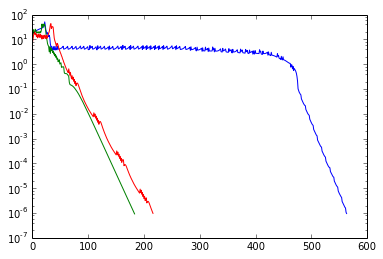

In [4]:
plt.plot(ans1[0],'b')
plt.plot(ans2[0],'g')
plt.plot(ans3[0],'r')
plt.yscale('log')
plt.show()

For small dimensions it is better to not use the sparse representations:

In [22]:
N = 10000
ans1 = tseng_fbf_linesearch(F, prox_g, z0, delta=1.5, numb_iter=N)
ans2 = alg_VI_proj(F, prox_g, z0, tau_0=1, constr=True, numb_iter=N)
ans3 = alg_VI_prox(F, prox_g, z0, numb_iter=N)

1.5541156265370761e-06